# Default Credit Card Client Predictor 
Author: Jacqueline Chong, Junrong Zhu, Lianna Hovhannisyan, Macy Chan

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import PolynomialFeatures

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV

from sklearn.metrics import (roc_auc_score, classification_report,
    confusion_matrix)

from sklearn.model_selection import cross_val_predict

In [2]:
#Adapted from lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## 1. Introduction <a name="2"></a>
<hr>

In this mini project, a classification problem of predicting whether a credit card client will default or not. For this problem, [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) is used. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. For additional information about the data set, [a associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719) is available through [the UBC library](https://www.library.ubc.ca/). 

<br><br>

<br>The dataset is based on Taiwan’s credit card client default cases from April to September. It has 30000 examples, and each example represents particular client’s information. The dataset has 24 observations with respective values such as gender, age, marital status, last 6 months bills, last 6 months payments, etc, including the final default payment of next month column: labeled 1 (client will make a default) and 0 (client will not make a default). The detailed description of each feature can be found [here]( https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). 

In [3]:
credit_card_df = pd.read_csv("data/UCI_Credit_Card.csv")
credit_card_df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
credit_card_df.shape

(30000, 25)

As seen from above, the data set does not possess any missing values. 

We have decided not to change the feature names are not changed, as we find them explanatory as such. 

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
1. Split the data into train and test portions.


In [6]:
train_df, test_df = train_test_split(credit_card_df, test_size = 0.3, random_state=123)

#target column name
target = 'default.payment.next.month'

X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [7]:
# printing the number of observations for train and test sets
print('The number of observations for train set: ', train_df[target].shape[0])
print('The number of observations for test set: ', test_df[target].shape[0])

The number of observations for train set:  21000
The number of observations for test set:  9000


</br> We decided to have 30% of the observations in the test data and 70% in the train data set. Overall the data set has 30,000 observations, thus the test set should have enough examples to provide good affirmation for the model: more precisely, the train set will have 21000 observations, and test set 9000.

<br><br>

## 3. EDA <a name="3"></a>
<hr>

In [8]:
# percentage of zeros and ones in default column train set
train_percent_defaults = train_df[target].value_counts(normalize=True) * 100
train_percent_defaults.name = 'Default Count Percent'

# count of observations were default is one or zero in train set 
train_yes_default = len(train_df[train_df[target] == 1])
train_no_default = len(train_df[train_df[target] == 0])

In [9]:
# convert to a dataframe and make column names readable
default_percent_df = pd.DataFrame(train_percent_defaults)
default_percent_df = default_percent_df.rename(index = {0: 'No (0)', 1: 'Yes (1)'})

# make a dictionary of classes count values 
count_dic_no = {"Count": train_no_default 
               }

count_dic_yes = {"Count": train_yes_default
                }

# make a list from classes default payment counts 
list_default = [count_dic_no, count_dic_yes]

# convert to a dataframe
default_count = pd.DataFrame(list_default, index = ['No (0)', 'Yes (1)'])

# join two dataframes
df_default = default_percent_df.join(default_count)
df_default

,Default Count Percent,Count
No (0),77.67619,16312
Yes (1),22.32381,4688


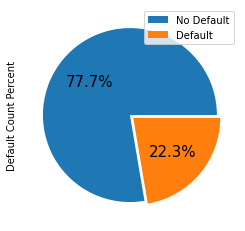

In [10]:
# Make a pie chart
df_default['Default Count Percent'].plot(kind='pie',labels = ['',''], autopct='%1.1f%%',
                        explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['No Default', 'Default'])
plt.show()

3. The count, as well as percentage of overall distribution of classes indicates that there is an imbalance between No (0) and Yes (1) classes. Overall, we are more interested in minimizing Type I error (predicting no default payment, when in reality the client made a default payment the following month), as opposed to Type II error (predicting default payment, when in reality no default payment was made by the client). For the creditors, it is for upmost importance to have the model that correctly predicts the account’s next month status, especially if the client is going to make a default payment. The correct prediction will help creditors to plan their risk and budget management better and take steps before the situation gets out of control.

In [11]:
scoring_metric = ["f1", "recall", "average_precision"]

4. Therefore, as we have class imbalance, accuracy will not be used for evaluation of the model. The chosen scoring metric includes F1 score, recall, and average precision. F1 score is the harmonic mean of recall and precision score providing a good idea about both scores, thus it will be our primary scoring metric throughout evaluation. 

Let's examine the relation between the amount of given credit and the default accounts. As the examination is for the credit companies, the amount of given credit to the person should reflect the trust the company has towards individual. Thus the relation between default and given credit amount is at upmost interest for our analysis. 

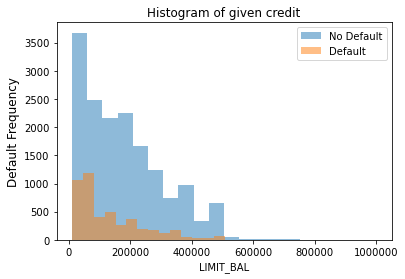

In [12]:
#Plot the histograms: Extracted from skeleton code from lab2, 571 class 
ax = train_df.groupby(target)['LIMIT_BAL'].plot.hist(bins=20, alpha=0.5, legend=True)
plt.xlabel('LIMIT_BAL')
plt.title("Histogram of given credit")
plt.legend(labels=['No Default', 'Default'])
plt.ylabel("Default Frequency", fontsize= 12)
plt.ticklabel_format(style='plain', axis='x')

plt.show()

Indeed we can see from the plot, that as the amount of given credit is getting higher, the less accounts tend to have defaults. 

By looking at the relation of bill statements and frequency of defaulting the credit, we see the same relation: higher bill statement results in less default accounts.

In [13]:
#Column names for bill payment
numeric_cols_bill = ['BILL_AMT1', 'BILL_AMT2',
                'BILL_AMT3', 'BILL_AMT4','BILL_AMT5']

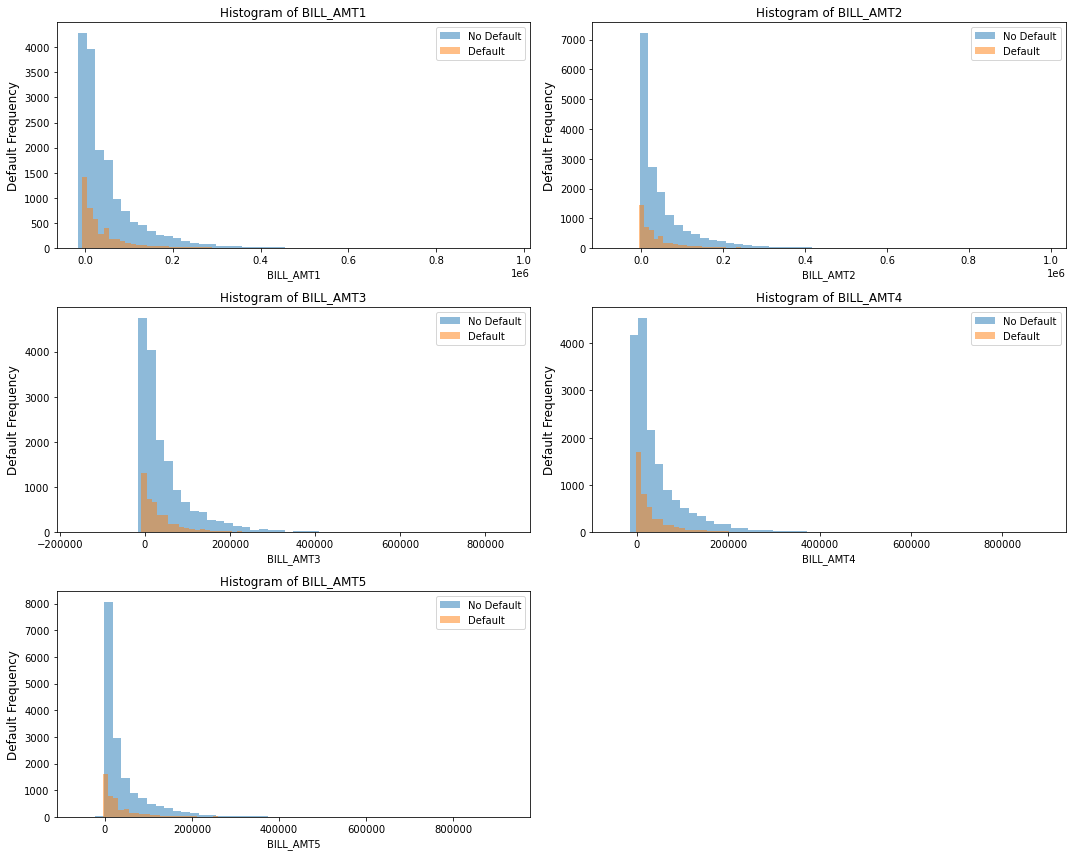

In [14]:
#Specifying the size of figures
plt.figure(figsize=(15,12))

# Plot the histograms: Extracted from skeleton code from lab2, 571 class
for i, col in enumerate(numeric_cols_bill):
    plt.subplot(3, 2, i + 1)
    ax = train_df.groupby(target)[col].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(col)
    plt.title("Histogram of " + col)
    plt.legend(labels=['No Default', 'Default'])
    plt.ylabel("Default Frequency", fontsize= 12)
    plt.tight_layout()
    
plt.show()

We should be very careful while examining such sensitive data as the gender. As shown in the Table below, we have more females, than males in our data set.

In [15]:
#count of observations were default is one or zero in train set 
train_gender_male = len(train_df[train_df[target] == 1])
train_gender_female = len(train_df[train_df[target] == 0])

#make a dictionary of classes count values 
count_dic_male = {"Count": train_gender_male 
               }

count_dic_female = {"Count": train_gender_female
                }

#make a list 
list_gender = [count_dic_male, count_dic_female]

#make a dataframe
gender_count = pd.DataFrame(list_gender, index = ['Male', 'Female'])
gender_count

,Count
Male,4688
Female,16312


But we can see from the diagram and summary statistic table, that the likelihood of males to make a default payment is higher than for females. This is interesting observation, however we acknowledge that we are dealing with the limited amount of data and that other factors may have influenced such statistics. Usage of sensitive data such as gender should be at upmost importance, but as our model is not causing direct harm to a particular group, we decide to keep it among our features.

In [16]:
#get the percentage of the likelihood of default vs no default payment by gender
gender_default_percent = pd.DataFrame(train_df.groupby(target)['SEX'].value_counts(normalize = True) * 100)

#save in the dictionary the values for the percentage of default payment only
dict_gender = {'Default Percentage': gender_default_percent['SEX'].values.tolist()[2:]
              }

df_gender = pd.DataFrame(dict_gender, index = ["Male", "Female"])
df_gender

,Default Percentage
Male,55.84471
Female,44.15529


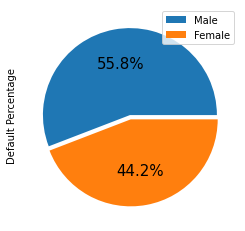

In [17]:
df_gender['Default Percentage'].plot(kind='pie',labels = ['',''], autopct='%1.1f%%',
                        explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Male', 'Female'])
plt.show()

<br><br>

## 4. Feature engineering <a name="3"></a>
<hr>

We decided to add the features 'avg_bill_amt' and 'avg_pay_amt'. Apart from having individual payment/bill columns, such as PAY_0 to PAY_6 and BILL_AMT1 to BILL_AMT6, adding the average pay column ('avg_pay_amt') and average bill column ('avg_bill_amt') will better reflect the overall credit card payment/spending pattern as they would possibly provide useful information to train the model.

In [18]:
X_train["avg_bill_amt"] = X_train.loc[:, "BILL_AMT1":"BILL_AMT6"].mean(axis=1)
X_train["avg_pay_amt"] = X_train.loc[:, "PAY_AMT1":"PAY_AMT6"].mean(axis=1)

X_test["avg_bill_amt"] = X_test.loc[:, "BILL_AMT1":"BILL_AMT6"].mean(axis=1)
X_test["avg_pay_amt"] = X_test.loc[:, "PAY_AMT1":"PAY_AMT6"].mean(axis=1)

# convert feature types for later value reordering
X_train = X_train.astype(
    {
        "PAY_0": "str",
        "PAY_2": "str",
        "PAY_3": "str",
        "PAY_4": "str",
        "PAY_5": "str",
        "PAY_6": "str",
    }
)

# convert feature types for later value reordering
X_test = X_test.astype(
    {
        "PAY_0": "str",
        "PAY_2": "str",
        "PAY_3": "str",
        "PAY_4": "str",
        "PAY_5": "str",
        "PAY_6": "str",
    }
)

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>

|     Type | Reason                                                                                                                                                                                                                                         | Features                                                                                                                                                                                                |
|---------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| category |All of these features have fixed number of categories. `MARRIAGE` has 4 classes, and we consider it as categorical instead of ordinal feature because we didn't want to be biased and rank different status in any particular order, similar reasoning for `SEX` feature. For `EDUCATION`, there are some values shown as `unknown` and `others`. Since the meanings behind them are vague, we do not want to group them together as they may have unique patterns among all the `unknowns` or all the `others`, thus we decided to treat them as categorical feature.  | `SEX`, `MARRIAGE`, `EDUCATION`                                                                                                                                                                          |
| ordinal  | Sequential numbers ranged from -2 to 8 (-2 as the best, 8 as the worst).                                                                                                                                                                       | `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6`                                                                                                                                                    |
| numeric  | Numeric columns needs standardization                                                                                                                                                                                                                       | `PAY_AMT1`, `PAY_AMT2`, `PAY_AMT5`, `AGE`, `BILL_AMT5`, `PAY_AMT4`, `BILL_AMT6`, `BILL_AMT2`, `BILL_AMT4`, `LIMIT_BAL`, `BILL_AMT1`, `BILL_AMT3`, `avg_bill_amt`, `avg_pay_amt`, `PAY_AMT3`, `PAY_AMT6` |
| drop     | Unique identifier for every record in the data set (wouldn't be helpful for model training)                                                                                                                                                                                                         | `ID`                                                                                                                                                                                                    |

In [19]:
# differing orders were requires as PAY_5 and PAY_6 were missing a value
ordering_pay0_pay4 = ['8', '7', '6', '5', '4', '3', '2', '1', '0', '-1', '-2']
ordering_pay5_pay6 = ['8', '7', '6', '5', '4', '3', '2', '0', '-1', '-2']

In [20]:
category_feats = ["SEX", "MARRIAGE", "EDUCATION"]
ordinal_feats_pay_1 = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4']
ordinal_feats_pay_2 = ['PAY_5', 'PAY_6']
ordering_pay_1 = [ordering_pay0_pay4] * len(ordinal_feats_pay_1)
ordering_pay_2 = [ordering_pay5_pay6] * len(ordinal_feats_pay_2)
drop_feats = ['ID']

numeric_feats  = list(set(X_train.columns)
            - set(category_feats)
            - set(ordinal_feats_pay_1)
            - set(ordinal_feats_pay_2)
            - set(drop_feats)
        )

preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (StandardScaler(), numeric_feats),
    (OrdinalEncoder(categories=ordering_pay_1), ordinal_feats_pay_1),
    (OrdinalEncoder(categories=ordering_pay_2), ordinal_feats_pay_2),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), category_feats),
)
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('drop', 'drop', ['ID']),
                                ('standardscaler', StandardScaler(),
                                 ['PAY_AMT3', 'PAY_AMT2', 'PAY_AMT5',
                                  'BILL_AMT6', 'PAY_AMT4', 'BILL_AMT2',
                                  'PAY_AMT6', 'BILL_AMT5', 'avg_pay_amt', 'AGE',
                                  'BILL_AMT3', 'BILL_AMT1', 'PAY_AMT1',
                                  'avg_bill_amt', 'BILL_AMT4', 'LIMIT_BAL']),
                                ('ordinalencoder-1',
                                 OrdinalEncoder(categories=[['8', '7', '6', '5',
                                                             '4', '3',...
                                                             '0', '-1', '-2'],
                                                            ['8', '7', '6', '5',
                                                             '4', '3', '2', '1',
                                                   

<br><br><br><br>

## 6. Baseline model <a name="6"></a>
<hr>

In [21]:
results = {}

In [22]:
dummy = DummyClassifier()
baseline_pipe = make_pipeline(preprocessor, dummy)
results['dummy'] = mean_std_cross_val_scores(make_pipeline(preprocessor, dummy), X_train, y_train, 
                                             return_train_score=True, scoring=scoring_metric)

In [23]:
pd.DataFrame(results).T

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_average_precision,train_average_precision
dummy,0.036 (+/- 0.007),0.022 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.223 (+/- 0.000),0.223 (+/- 0.000)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>

In [24]:
#pipe logistic regression
pipe_logisticregression = make_pipeline(preprocessor,
                           LogisticRegression(max_iter=2000, 
                                             random_state=123))

In [25]:
#save in the results logistic regression score
results["LogisticReg"] = mean_std_cross_val_scores(pipe_logisticregression, 
                                                   X_train, 
                                                   y_train, 
                                                   return_train_score=True,
                                                   scoring = scoring_metric)
pd.DataFrame(results)

,dummy,LogisticReg
fit_time,0.036 (+/- 0.007),1.523 (+/- 0.200)
score_time,0.022 (+/- 0.001),0.025 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.372 (+/- 0.015)
train_f1,0.000 (+/- 0.000),0.374 (+/- 0.008)
test_recall,0.000 (+/- 0.000),0.254 (+/- 0.013)
train_recall,0.000 (+/- 0.000),0.255 (+/- 0.007)
test_average_precision,0.223 (+/- 0.000),0.507 (+/- 0.016)
train_average_precision,0.223 (+/- 0.000),0.509 (+/- 0.004)


We will carry out hyperparameter optimization: C controls the regularization, and class_weight hyperparameter for tackling class imbalance. 

In [26]:
#parameters for logistic regression
param_dist_lg = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                 'logisticregression__class_weight': ['balanced', None]}

#randomized search to find the best parameters
random_search_lg = RandomizedSearchCV(
    pipe_logisticregression, 
    param_dist_lg,
    n_jobs=-1,
    return_train_score=True,
    scoring = scoring_metric,
    refit='f1',
    random_state=123
)

In [27]:
random_search_lg.fit(X_train, y_train)
print("Best parameter values are:", random_search_lg.best_params_)
print("Best cv score is:", random_search_lg.best_score_)

Best parameter values are: {'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.1}
Best cv score is: 0.4919653206118707


In [28]:
#make optimized parameters pipeline
pipe_logisticregression_opt = make_pipeline(preprocessor,
                                            LogisticRegression(max_iter=2000,
                                                               C = 0.1,
                                                               class_weight = 'balanced',
                                                               random_state=123))

In [29]:
results['LogisticReg_opt'] = mean_std_cross_val_scores(pipe_logisticregression_opt, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True,
                                                       scoring = scoring_metric)

In [30]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt
fit_time,0.036 (+/- 0.007),1.523 (+/- 0.200),0.856 (+/- 0.144)
score_time,0.022 (+/- 0.001),0.025 (+/- 0.002),0.030 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.372 (+/- 0.015),0.492 (+/- 0.006)
train_f1,0.000 (+/- 0.000),0.374 (+/- 0.008),0.493 (+/- 0.003)
test_recall,0.000 (+/- 0.000),0.254 (+/- 0.013),0.643 (+/- 0.017)
train_recall,0.000 (+/- 0.000),0.255 (+/- 0.007),0.643 (+/- 0.003)
test_average_precision,0.223 (+/- 0.000),0.507 (+/- 0.016),0.504 (+/- 0.016)
train_average_precision,0.223 (+/- 0.000),0.509 (+/- 0.004),0.505 (+/- 0.004)


In [31]:
lr = confusion_matrix(y_train, cross_val_predict(pipe_logisticregression_opt, X_train, y_train))
lr

array([[11758,  4554],
       [ 1672,  3016]])

We can see that with optimized hyperparameters, Logistic Regression is doing much better. However, it is obvious that we are dealing with underfitting (almost no gap between scores). The std is very small ranging in +- 0.01. 

From confusion matrix, we can see that we have a lot more FPs, then FNs, which is also visible in the average precision and f1 scores. Overall goal is to maximize the f1 score, thus in the later exercise we will look at non-linear models to see if we can beat this score.   

<br><br>

## 8. Different models <a name="8"></a>
<hr>

In [32]:
models = {}

In [33]:
#Random Forest pipe
pipe_rf = make_pipeline(preprocessor, 
                        RandomForestClassifier(random_state=123))
models["RandomForest"] = pipe_rf

#XGBoost pipe
pipe_xgb = make_pipeline(preprocessor, 
                         XGBClassifier(random_state=123, 
                                       eval_metric="logloss", 
                                       verbosity=0,
                                       use_label_encoder=False))
models["XGBoost"] = pipe_xgb

#LGBM Classifier pipe
pipe_lgbm = make_pipeline(preprocessor, 
                          LGBMClassifier(random_state=123))
models["LGBM"] = pipe_lgbm

#Catboost pipe
pipe_catb = make_pipeline(preprocessor, 
                          CatBoostClassifier(verbose=0, 
                                             random_state=123))
models["Cat_Boost"] = pipe_catb

#summarize mean cv scores in result_non_linear
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
    model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [34]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost
fit_time,0.036 (+/- 0.007),1.523 (+/- 0.200),0.856 (+/- 0.144),4.804 (+/- 0.184),3.652 (+/- 0.232),1.419 (+/- 0.276),9.084 (+/- 1.947)
score_time,0.022 (+/- 0.001),0.025 (+/- 0.002),0.030 (+/- 0.002),0.231 (+/- 0.034),0.077 (+/- 0.027),0.111 (+/- 0.031),0.142 (+/- 0.024)
test_f1,0.000 (+/- 0.000),0.372 (+/- 0.015),0.492 (+/- 0.006),0.473 (+/- 0.009),0.469 (+/- 0.009),0.481 (+/- 0.015),0.473 (+/- 0.011)
train_f1,0.000 (+/- 0.000),0.374 (+/- 0.008),0.493 (+/- 0.003),0.999 (+/- 0.000),0.744 (+/- 0.003),0.585 (+/- 0.006),0.608 (+/- 0.007)
test_recall,0.000 (+/- 0.000),0.254 (+/- 0.013),0.643 (+/- 0.017),0.374 (+/- 0.009),0.371 (+/- 0.006),0.375 (+/- 0.013),0.371 (+/- 0.010)
train_recall,0.000 (+/- 0.000),0.255 (+/- 0.007),0.643 (+/- 0.003),0.998 (+/- 0.000),0.622 (+/- 0.003),0.459 (+/- 0.007),0.484 (+/- 0.007)
test_average_precision,0.223 (+/- 0.000),0.507 (+/- 0.016),0.504 (+/- 0.016),0.540 (+/- 0.015),0.533 (+/- 0.019),0.563 (+/- 0.018),0.560 (+/- 0.019)
train_average_precision,0.223 (+/- 0.000),0.509 (+/- 0.004),0.505 (+/- 0.004),1.000 (+/- 0.000),0.900 (+/- 0.004),0.765 (+/- 0.004),0.767 (+/- 0.005)


Default parameters reasoning:

All the non-linear models are overfitting, but compared to `RandomForest` and `XGBoost`, the `LGBM` and `CatBoost` are overfitting less the train data, as the gap between train and validation scores is lower. The worst model in regards of overfitting is RandomForest with almost perfect one score in train set, and lower than 0.5 scores on cross validation set (for `f1` score). Logistic Regression is underfitting, the training score is low and the gap between train and validation score is very small. Similarly dummy is underfitting.   

`LGBM Classifier` has the lowest fit time and compared to all non linear models, the difference is quite high. `Random Forest` and `CatBoost` have the longest fit time, with latest being the slowest overall. 

Score time for all classifiers is fast, except random forest. It is still fast, but compared to other models, we can notice difference of around 0.1s.

Stability of scores is more or less stable, with standard deviation ranging in around 0.01. 

`RandomForest` gives better `recall` and `average precision` scores compared to `XGboost` cross validation score, however `f1` score is lower compared to other non-linear models. 

The best model among non-linear models is `LGBM Classifier`. Despite overfitting, it is giving us the best `f1` + `average precision` score, as well as the lowest fit and score time. The worst model is `Random Forest`, `XGBoost`, as they have the lowest f1 score among non-linear models, and take a long time to fit. 

As for `Logistic Regression`, it gives us **best** score (except for average precision) in `recall` and `f1` score. Regarding `recall`, `f1` scores and speed, `LGBM` is the only non-linear model which can be comparable to `Logistic Regression`. 

Thus, we cannot conclude that non-linear models beat linear models.

<br><br>

## 9. Feature selection <a name="9"></a>
<hr>

In [35]:
result_feature_select = {}

In [36]:
rfecv = RFECV(Ridge())

pipe_rf_rfecv = make_pipeline(
    preprocessor, rfecv, LGBMClassifier(random_state=123)
)

result_feature_select["rf+rfecv"] = mean_std_cross_val_scores(
    pipe_rf_rfecv, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [37]:
pd.DataFrame(result_feature_select)

,rf+rfecv
fit_time,1.475 (+/- 0.102)
score_time,0.072 (+/- 0.005)
test_f1,0.478 (+/- 0.012)
train_f1,0.565 (+/- 0.024)
test_recall,0.372 (+/- 0.010)
train_recall,0.441 (+/- 0.024)
test_average_precision,0.554 (+/- 0.016)
train_average_precision,0.731 (+/- 0.027)


After including feature selection, the cv scores did not improve compared to our best non linear model `LGBM`: all three cv scores f1, average precision and recall decreased. Even though, the overfitting is less (the gap between train and cv score), we do not see improvement by including feature selection in overall performance.

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

We will start from `RandomForest Classifier` and optimize three of its hyperparameters: **n_estimators** which determines the number of trees in the forest, **max_depth** determines the number of levels in the tree, and **class_weight** which is used for tackling class imbalance (controls weights associated with the classes). 

In [38]:
param_grid_rf = {
     "randomforestclassifier__n_estimators": np.linspace(start=200, stop=500, num=5, dtype=int),
     "randomforestclassifier__max_depth": np.linspace(start=10, stop=110, num=5, dtype=int),
     "randomforestclassifier__class_weight": ['balanced', None]
}

In [39]:
random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_grid_rf,
    n_jobs=-1,
    n_iter=6,
    scoring="f1",
    cv=5,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

/Users/jzhu/opt/miniconda3/envs/573/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['PAY_AMT3',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PA

In [40]:
print("Best hyperparameter values for Random Forest: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values for Random Forest:  {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': 'balanced'}
Best score: 0.545


The next we will optimize hyperparameter for `XGBoost`. We will optimize the **max_depth** hyperparameter, which determines the maximum depth of a tree (more depth, more complex model). 

In [41]:
param_grid_xgb = {
     "xgbclassifier__max_depth": np.arange(5, 25, 3),
}

In [42]:
random_search_xgboost = RandomizedSearchCV(
    pipe_xgb,
    param_grid_xgb,
    n_jobs=-1,
    n_iter=6,
    scoring="f1",
    cv=5,
    random_state=123,
    return_train_score=True,
)

random_search_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['PAY_AMT3',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PA

In [43]:
print("Best hyperparameter values for XGBClassifier: ", random_search_xgboost.best_params_)
print("Best score: %0.3f" % (random_search_xgboost.best_score_))

Best hyperparameter values for XGBClassifier:  {'xgbclassifier__max_depth': 20}
Best score: 0.466


Next we will optimize hyperparameters for `LGBM Classifier`: **max_depth** which determines the depth of the tree, **num_leaves** which determines the number of leaves for base learners, and the **class_weight** hyperparameter for tackling class imbalance (controls weights associated with the classes).  

In [44]:
param_grid_lgbm = {
     "lgbmclassifier__max_depth": np.arange(5, 25, 3),
     "lgbmclassifier__num_leaves": np.arange(20, 200, 20),
     "lgbmclassifier__class_weight": ['balanced', None]
}

In [45]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_jobs=-1,
    n_iter=6,
    scoring="f1",
    cv=5,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['PAY_AMT3',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PA

In [46]:
print("Best hyperparameter values for LGBMlassifier: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

Best hyperparameter values for LGBMlassifier:  {'lgbmclassifier__num_leaves': 100, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__class_weight': 'balanced'}
Best score: 0.546


Lastly, we will perform hyperparamaters optimization for `CatBoost Classifier`: **max_depth** which determines the the depth of the tree, **learning_rate** which controls the gradient step size (smaller size, more iterations) and can help to minimize the error associated with the Loss function, and **auto_class_weights** which determines the weight given to each class.  

In [47]:
param_grid_cat = {
     "catboostclassifier__max_depth": np.arange(5, 15, 2),
     "catboostclassifier__learning_rate": np.linspace(0.1,0.2,5),
     "catboostclassifier__auto_class_weights": ["None", "Balanced"]
}

In [48]:
random_search_cat = RandomizedSearchCV(
    pipe_catb,
    param_grid_cat,
    n_jobs=-1,
    n_iter=6,
    scoring="f1",
    cv=5,
    random_state=123,
    return_train_score=True,
)

random_search_cat.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['PAY_AMT3',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PA

In [49]:
print("Best hyperparameter values for CatBoost: ", random_search_cat.best_params_)
print("Best score: %0.3f" % (random_search_cat.best_score_))

Best hyperparameter values for CatBoost:  {'catboostclassifier__max_depth': 5, 'catboostclassifier__learning_rate': 0.125, 'catboostclassifier__auto_class_weights': 'Balanced'}
Best score: 0.522


We are going to group classifiers with optimized arguments in the dictionary and get mean cross validation scores for each to summarize them in the `results` dictionary. They will appear with the 'unoptimized' versions, thus it will be easier to compare. 

In [50]:
classifiers = {
    "random_forest_opt": make_pipeline(preprocessor, 
                                   RandomForestClassifier(random_state=123,
                                                          n_estimators=200, 
                                                          max_depth=10, 
                                                          class_weight='balanced')),
    "XGBoost_opt": make_pipeline(preprocessor, 
                                 XGBClassifier(random_state=123, 
                                               eval_metric="logloss", 
                                               verbosity=0,
                                               max_depth = 20,
                                               use_label_encoder =False)),
    "LightGBM_opt": make_pipeline(preprocessor, 
                                  LGBMClassifier(random_state=123,
                                                 num_leaves=100,
                                                 max_depth= 5,
                                                 class_weight = 'balanced')),
    "CatBoost_opt": make_pipeline(preprocessor, 
                                  CatBoostClassifier(verbose=0,
                                                     random_state=123,
                                                     max_depth = 5, 
                                                     learning_rate = 0.125,
                                                     auto_class_weights = 'Balanced')),
}

In [51]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
    model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [52]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost,random_forest_opt,XGBoost_opt,LightGBM_opt,CatBoost_opt
fit_time,0.036 (+/- 0.007),1.523 (+/- 0.200),0.856 (+/- 0.144),4.804 (+/- 0.184),3.652 (+/- 0.232),1.419 (+/- 0.276),9.084 (+/- 1.947),6.074 (+/- 0.767),9.876 (+/- 0.544),0.634 (+/- 0.205),6.082 (+/- 0.549)
score_time,0.022 (+/- 0.001),0.025 (+/- 0.002),0.030 (+/- 0.002),0.231 (+/- 0.034),0.077 (+/- 0.027),0.111 (+/- 0.031),0.142 (+/- 0.024),0.243 (+/- 0.036),0.080 (+/- 0.010),0.072 (+/- 0.010),0.130 (+/- 0.009)
test_f1,0.000 (+/- 0.000),0.372 (+/- 0.015),0.492 (+/- 0.006),0.473 (+/- 0.009),0.469 (+/- 0.009),0.481 (+/- 0.015),0.473 (+/- 0.011),0.545 (+/- 0.018),0.466 (+/- 0.013),0.546 (+/- 0.014),0.522 (+/- 0.010)
train_f1,0.000 (+/- 0.000),0.374 (+/- 0.008),0.493 (+/- 0.003),0.999 (+/- 0.000),0.744 (+/- 0.003),0.585 (+/- 0.006),0.608 (+/- 0.007),0.653 (+/- 0.001),0.998 (+/- 0.000),0.617 (+/- 0.002),0.817 (+/- 0.004)
test_recall,0.000 (+/- 0.000),0.254 (+/- 0.013),0.643 (+/- 0.017),0.374 (+/- 0.009),0.371 (+/- 0.006),0.375 (+/- 0.013),0.371 (+/- 0.010),0.553 (+/- 0.012),0.378 (+/- 0.011),0.615 (+/- 0.015),0.564 (+/- 0.008)
train_recall,0.000 (+/- 0.000),0.255 (+/- 0.007),0.643 (+/- 0.003),0.998 (+/- 0.000),0.622 (+/- 0.003),0.459 (+/- 0.007),0.484 (+/- 0.007),0.669 (+/- 0.005),0.997 (+/- 0.001),0.695 (+/- 0.005),0.931 (+/- 0.005)
test_average_precision,0.223 (+/- 0.000),0.507 (+/- 0.016),0.504 (+/- 0.016),0.540 (+/- 0.015),0.533 (+/- 0.019),0.563 (+/- 0.018),0.560 (+/- 0.019),0.557 (+/- 0.021),0.527 (+/- 0.015),0.565 (+/- 0.021),0.533 (+/- 0.017)
train_average_precision,0.223 (+/- 0.000),0.509 (+/- 0.004),0.505 (+/- 0.004),1.000 (+/- 0.000),0.900 (+/- 0.004),0.765 (+/- 0.004),0.767 (+/- 0.005),0.740 (+/- 0.004),1.000 (+/- 0.000),0.682 (+/- 0.004),0.893 (+/- 0.002)


We can notice that after optimization, we are getting better cross validation scores in all non-linear models. 

The overfitting seems to be better in comparison with "unoptimized" models, however all models seem to still overfit. RandomForest is giving us much better results, the difference between cv and train score gap is much less, and all other scores are up. In fact, the scores became competitive with the other non-linear models. After optimization, CatBoost seems to overfit more. 

Std is low for all models. 

The best model after hyperparameter optimization is `LGBM Classifier`, which gives us the highest cv `f1 score`, and is the fastest among all models. Even though logistic regression has higher recall score, then LGBM, in overall performance we are more prioritizing f1 score. Also the difference between score and fit time between LGBM and logistic regression is not very large, and we can say that both models are quick. Thus we are choosing LGBM as our final model with hyperparameters as follow: 'lgbmclassifier__num_leaves': 100, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__class_weight': 'balanced' and the f1 score of 0.546.

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>

In [53]:
import eli5

In [54]:
pipe_feats = make_pipeline(preprocessor, LGBMClassifier(random_state=123,
                                            num_leaves=100,
                                            max_depth= 5,
                                            class_weight = 'balanced'))
pipe_feats.fit(X_train, y_train)

feature_names = list(numeric_feats + ordinal_feats_pay_1 + ordinal_feats_pay_2 +
                     pipe_feats.named_steps["columntransformer"].named_transformers_['onehotencoder'].get_feature_names_out().tolist())

In [55]:
random_search_lgbm

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['PAY_AMT3',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PA

In [56]:
eli5.explain_weights(pipe_feats.named_steps['lgbmclassifier'], feature_names=feature_names)

Weight,Feature
0.4756,PAY_0
0.0457,LIMIT_BAL
0.0445,avg_pay_amt
0.0402,BILL_AMT1
0.0388,PAY_AMT2
0.0300,PAY_AMT3
0.0298,PAY_3
0.0296,PAY_AMT1
0.0262,PAY_2
0.0243,avg_bill_amt


In [57]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


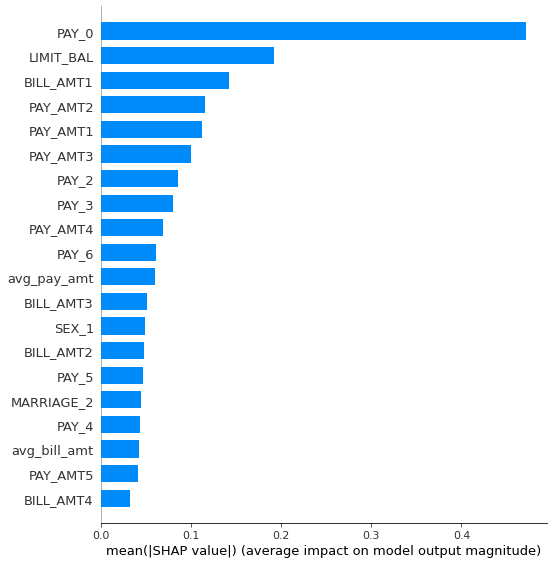

In [58]:
import shap

lgbm_explainer = shap.TreeExplainer(pipe_feats.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type='bar')

We examined the most important features of `LGBMClassifier` with both SHAP and eli5 methods. The results from these two method are somewhat similar, as 4 out of 5 top features from `eli5` are the top 4 features in `SHAP` method (the top 4 are: `PAY_0`, `LIMIT_BAL` , `BILL_AMT1` and `PAY_AMT2` respectively). 

From the SHAP summary plot, it's easy to spot that `PAY_0` has significantly larger mean absolute SHAP value comparing to all other features. Similarly, the top feature `PAY_0` has a much larger weight among all the features in`eli5` output table. 

On the contrary, some equally important features in `eli5` is ranked differently in SHAP.

Something interesting from the result here is that, having PAY_0 as the most important is assuming that the payment status in September is the most essential feature among all the variables, but this doesn't align with the reality.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

In [59]:
from sklearn.metrics import average_precision_score, f1_score, recall_score

predictions = random_search_lgbm.predict(X_test)

print("Test Set f1 score: ", round(f1_score(y_test, predictions), 3))
print(
    "Test Set average precision score: ",
    round(average_precision_score(y_test, random_search_lgbm.predict_proba(X_test)[:, 1]),3))
print("Test Set recall score: ", round(recall_score(y_test, predictions), 3))


Test Set f1 score:  0.532
Test Set average precision score:  0.541
Test Set recall score:  0.609


In [60]:
print("Validation Set f1 score: ", 
      pd.DataFrame(results).T.loc[['LightGBM_opt'], ['test_f1']]['test_f1'][0])
print("Validation Set average precision score: ",
      pd.DataFrame(results).T.loc[['LightGBM_opt'], ['test_average_precision']]['test_average_precision'][0])
print("Validation Set recall score: ", 
      pd.DataFrame(results).T.loc[['LightGBM_opt'], ['test_recall']]['test_recall'][0])


Validation Set f1 score:  0.546 (+/- 0.014)
Validation Set average precision score:  0.565 (+/- 0.021)
Validation Set recall score:  0.615 (+/- 0.015)


The test set's score were slightly lower than the validation score. As the training and test set is rather large, 21000, and 9000 respectively, we trust our results. 
Optimization bias occurs when the training set is small and many models are evaluated during hyperparameter optimization, which might cause us to get a good validation score 'by chance'. However, since both the validation and test scores are comparable, we do not think that we had issues with optimization bias. 

### Part 3

In [61]:
# Encoding X_test for SHAP force plot
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.shape

(9000, 35)

In [62]:
# Create an explainer for X_test_enc
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
test_lgbm_shap_values[1].shape

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


(9000, 35)

In [63]:
#Resetting index to explain X_test predictions
y_test_reset = y_test.reset_index(drop=True)

Splitting the classes into two separate lists. One for no_default and the other for yes_default:

In [64]:
nodefault = y_test_reset[y_test_reset == 0].index.tolist()
yesdefault = y_test_reset[y_test_reset == 1].index.tolist()

# chose the 10th row of each yes/no prediction in X_test
ex_nodefault = nodefault[10]
ex_yesdefault = yesdefault[10]

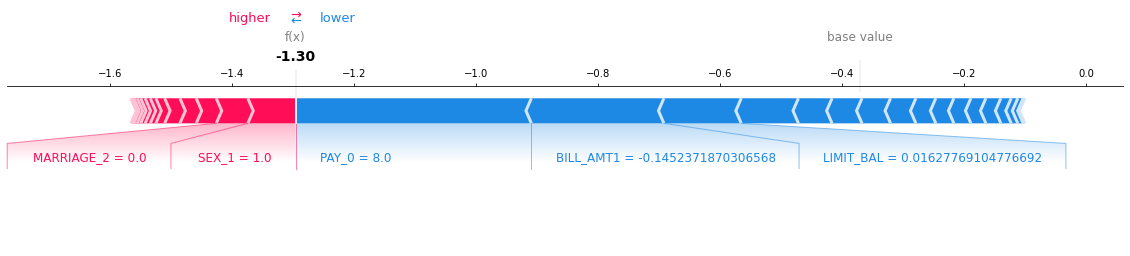

In [65]:
# Force Plot for prediction of 10th row (no_default)

shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_nodefault, :],
    X_test_enc.iloc[ex_nodefault, :],
    matplotlib=True,
)

- As seen from the plot, the raw score is much smaller than the base value, which predict accurately as no-default (class of '0'). 
- Sex_1 = 1.0, and Marriage_2 = 0.0, are pushing the prediction towards a higher score, and then PAY_0 = 8.0, BILL_AMT1 = -0.145, LIMIT_BAL = 0.0162 are pushing the prediction towards a lower score.

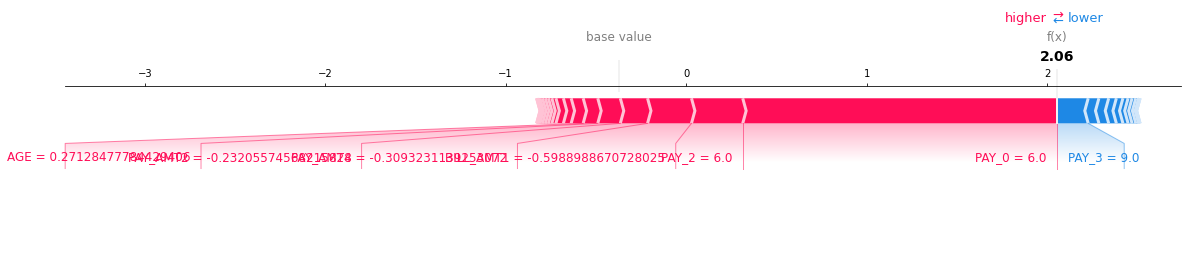

In [66]:
# Force Plot for prediction of 10th row (yes_default)

shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_yesdefault, :],
    X_test_enc.iloc[ex_yesdefault, :],
    matplotlib=True,
)

- As seen from the plot, the raw score is significantly higher than the base value, which is reflected in the prediction class of '1' which is a yes_default. 
- PAY_0 = 6.0 and PAY_2 = 6.0 are the features pushing the prediction towards higher scores, while PAY_3 = 9.0 is pushing the score towards a lower value. 

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>

In [67]:
pd.DataFrame(results).T.loc[['dummy', 'RandomForest', 'random_forest_opt', 'XGBoost_opt', 'LightGBM_opt', 'CatBoost_opt']]

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_average_precision,train_average_precision
dummy,0.036 (+/- 0.007),0.022 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.223 (+/- 0.000),0.223 (+/- 0.000)
RandomForest,4.804 (+/- 0.184),0.231 (+/- 0.034),0.473 (+/- 0.009),0.999 (+/- 0.000),0.374 (+/- 0.009),0.998 (+/- 0.000),0.540 (+/- 0.015),1.000 (+/- 0.000)
random_forest_opt,6.074 (+/- 0.767),0.243 (+/- 0.036),0.545 (+/- 0.018),0.653 (+/- 0.001),0.553 (+/- 0.012),0.669 (+/- 0.005),0.557 (+/- 0.021),0.740 (+/- 0.004)
XGBoost_opt,9.876 (+/- 0.544),0.080 (+/- 0.010),0.466 (+/- 0.013),0.998 (+/- 0.000),0.378 (+/- 0.011),0.997 (+/- 0.001),0.527 (+/- 0.015),1.000 (+/- 0.000)
LightGBM_opt,0.634 (+/- 0.205),0.072 (+/- 0.010),0.546 (+/- 0.014),0.617 (+/- 0.002),0.615 (+/- 0.015),0.695 (+/- 0.005),0.565 (+/- 0.021),0.682 (+/- 0.004)
CatBoost_opt,6.082 (+/- 0.549),0.130 (+/- 0.009),0.522 (+/- 0.010),0.817 (+/- 0.004),0.564 (+/- 0.008),0.931 (+/- 0.005),0.533 (+/- 0.017),0.893 (+/- 0.002)


Amongst the models, it is clear that the model that we have chosen `LightGBM_opt` is optimal in terms of total time required for fit and score, has the best f1 score, recall score, and average precision score. Moreover, the difference in scores between the test set and validation set are minimal, suggesting that there is minimal optimisation bias. Based on our test scores, which are highlighted in part 12 of this lab, our model is able to identify about **60.9% of the true default cases**, and **correctly identify 54.0% of all the default cases**. 

First, it is very important to highlight that discussion of the score and model should not be misinterpreted. For instance, the feature importance interpretation, our model suggested that PAY_0 weighted much more than other payments (PAY_1, PAY_2, etc.). In reality, we consider customer credit in a longer and consistent manner, which means payments made in every months should be treated equally. While the model suggested the payment in one particular month would weight much more than the rest months, hence we should not be overly confident/interpret our result of the model top importance features.

Moreover, as discussed in EDA, the gender imbalance is present in the dataset, and we believe to avoid further discussions and possible misinterpretation (ethical), it will be better to include an analysis of results for distinguished groups in later studies.


There is definitely room for improvement in our project, in terms of increasing its performance (CV score wise) and its interpretability. 

In terms of the choice of models, we could have attempted various ensemble methods, such as averaging and stacking to improve the performance of our model. It would allow us to combine different models, and potentially get better results. However, this would decrease interpretability, as there is randomness injected, and also reduce code maintainability, as each model needs to be optimized individually. 

In terms of the actual dataset, although we attempted to create new features, we did not test for correlation between pairs of the explanatory variables. We could have potentially calculated the variance inflation factor, and manually removed several features. While not a foolproof method and it will lend itself to a possibility of underfitting, we could have explored that option. 

In [11]:
!jt -r
!jupyter nbconvert --to html default_credit_card_client_predictor.ipynb --output "index.html"
!jt -t onedork

Reset css and font defaults in:
/Users/macychan/.jupyter/custom &
/Users/macychan/Library/Jupyter/nbextensions
[NbConvertApp] Converting notebook default_credit_card_client_predictor.ipynb to html
[NbConvertApp] Writing 979321 bytes to index.html
